# ML-Exercise 2

This notebook contains the second exercise of the Machine Learning for Visual Computing (183.605) lecture at TU Wien. Assignment via TUWEL. Please be aware of the deadlines in TUWEL.

* Upload a zip-file with the required programms. The programming language is python.
    1. Gaussian Process --> `solutions/gaussian_process.py`
    3. Vision Transformer --> `solutions/vision_transformer.py`
* If you needed additional conda or pip packages add an anaconda environment.yml to the zip-file
    1. conda env export > environment.yml
    2. See --> https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#sharing-an-environment

Important Note: In order to run the code error free, you need to install Latex locally. Alternatively, you can use JupyterHub, accessible via the TUWEL page.

##### Conda instructions

1. conda create --name MLVC-2
4. conda activate MLVC-2
5. conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
6. python -m pip install pillow matplotlib tqdm torchinfo ipykernel ipywidgets scikit-learn seaborn einops

In [7]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [8]:
!pip install utils

In [9]:
!pip install pillow matplotlib tqdm torchinfo pandas ipykernel nbformat ipywidgets scikit-learn tabulate cvxopt seaborn

In [10]:
!pip install latex

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import rcParams
import seaborn as sns

## Convert Dataset to PyTorch

In this section we first define some parameters like the number of training samples or the image size. Do the general imports and then we load the dataset and convert it to a PyTorch dataset.

In [12]:
NUM_SAMPLES = 10000  # Recommended: 10.000
TEST_RATIO = 0.2  # Recommended: 0.2
BATCH_SIZE = 64  # Recommended: 64
IMAGE_SIZE = 32  # Recommended: 32 (but you can also try 16, 64 or 128, depending on your hardware)
GET_ACCURACY_PER_EPOCH = False  # Recommended: False (takes a lot of time)


In [13]:
from tqdm import trange
import torch.optim as optim
from torchinfo import summary
from torch import nn
import torch
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np

from util.generate_dataset import make_dataset
from util.attention_visualizer import Visualizer
from solution_G_X.vision_transformer import VisionTransformer
from util.vision_transformer_util import CircleSquareDataset


(2000, 1024) (2000,) (8000, 1024) (8000,)


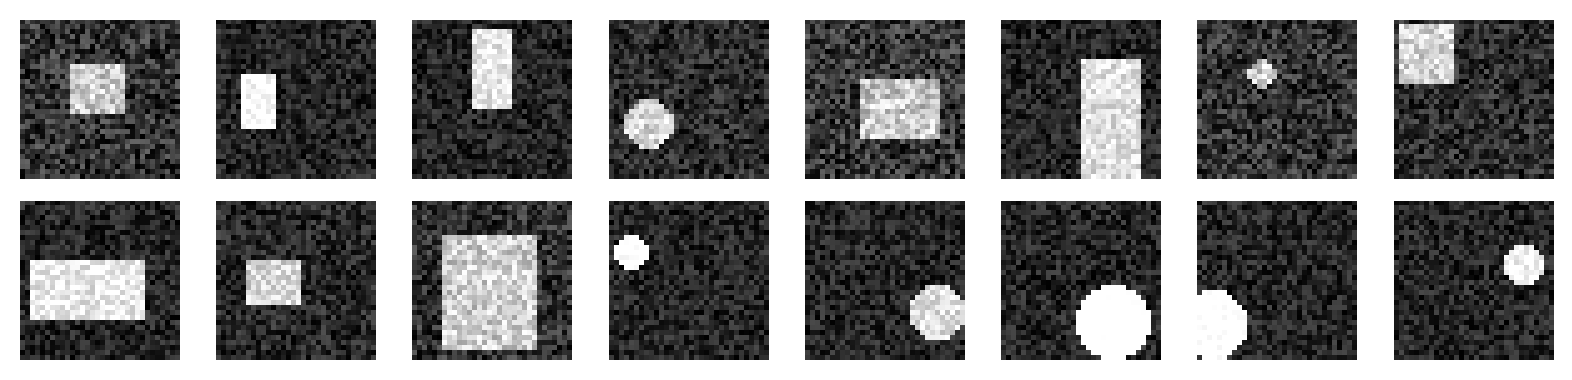

In [14]:
(dataset_train, labels_train), (dataset_test, labels_test) = make_dataset(
    NUM_SAMPLES, TEST_RATIO, IMAGE_SIZE
)

print(dataset_train.shape, labels_train.shape, dataset_test.shape, labels_test.shape)

dataset_pytorch_train = CircleSquareDataset(
    dataset_train, labels_train, image_size=IMAGE_SIZE
)
dataset_pytorch_test = CircleSquareDataset(
    dataset_test, labels_test, image_size=IMAGE_SIZE
)

train_dataloader = data.DataLoader(
    dataset_pytorch_train, shuffle=True, batch_size=BATCH_SIZE
)

test_dataloader = data.DataLoader(dataset_pytorch_test, shuffle=True, batch_size=1)

fig, axs = plt.subplots(2, 8, figsize=(8, 2), dpi=200)
axs = axs.reshape(-1)
for i, (x, y) in enumerate(train_dataloader):
    axs[i].imshow(x[0].sum(dim=0).reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap="gray")
    axs[i].axis('off')

    if i == 15:
        break
plt.tight_layout()
plt.show()

## Transformer (Encoder - Decoder)

In [15]:
# We check if a GPU is available and use it. To force CPU set: device = "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transf = VisionTransformer(
    image_size=IMAGE_SIZE,
    patch_size=4,
    num_classes=1,  # We don't predict classes
    dim=16,
    depth=2,
    heads=4,
    mlp_dim=64,
    dropout=0.3
)

# Convert transformer to selected device
transf = transf.to(device)

transf.train()

print(summary(transf, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)))

criterion = nn.BCELoss()
optimizer = optim.AdamW(transf.parameters(), lr=0.001)
loss_per_epoch = []
acc_per_epoch = []

GET_ACCURACY_PER_EPOCH = True
for epoch in trange(30):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, (data_, label_) in enumerate(train_dataloader, 0):
        # Convert data and label (target in lecture) to selected device
        data_ = data_.to(device)
        label_ = label_.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = transf(data_).squeeze()

        loss = criterion(outputs, label_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if GET_ACCURACY_PER_EPOCH:
        transf.eval()
        data_frame, acc = transf.predict(test_dataloader, device)
        transf.train()
        acc_per_epoch.append(acc)
    else:
        acc_per_epoch.append(0)

    loss_per_epoch.append(running_loss / len(train_dataloader))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(np.arange(len(acc_per_epoch)) + 1, acc_per_epoch)
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")

ax[1].plot(np.arange(len(loss_per_epoch)) + 1, loss_per_epoch)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")

fig.suptitle("Note that if accuracy is flat, please set GET_ACCURACY_PER_EPOCH to True")
plt.show()

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [64, 1]                   1,056
├─PatchEmbed: 1-1                        [64, 64, 16]              --
│    └─Conv2d: 2-1                       [64, 16, 8, 8]            784
├─ModuleList: 1-2                        --                        --
│    └─Block: 2-2                        [64, 65, 16]              --
│    │    └─LayerNorm: 3-1               [64, 65, 16]              32
│    │    └─Attention: 3-2               [64, 65, 16]              1,040
│    │    └─LayerNorm: 3-3               [64, 65, 16]              32
│    │    └─Mlp: 3-4                     [64, 65, 16]              2,128
│    └─Block: 2-3                        [64, 65, 16]              --
│    │    └─LayerNorm: 3-5               [64, 65, 16]              32
│    │    └─Attention: 3-6               [64, 65, 16]              1,040
│    │    └─LayerNorm: 3-7               [64, 65, 16]              32
│ 

 13%|█▎        | 4/30 [02:29<16:09, 37.31s/it]


KeyboardInterrupt: 

<div style="background-color:rgba(255, 255, 255, 1); text-align:center; vertical-align: middle; padding:40px 0;">

#### <span style="color:blue"> Potential transformer accuracy and loss.</span>
![h](img/transformer_loss.svg)

In [ ]:
transf.eval()
data_frame, acc = transf.predict(test_dataloader, device)
print(data_frame[0:20])
print("Test ACC:", acc)


     class  Pred  RAW_Pred  GT    Correct?
0   Square     1     0.997   1  ✔
1   Circle     0     0.003   0  ✔
2   Circle     0     0.003   0  ✔
3   Circle     0     0.003   0  ✔
4   Square     1     0.997   1  ✔
5   Square     1     0.986   1  ✔
6   Square     1     0.997   1  ✔
7   Square     1     0.995   1  ✔
8   Circle     0     0.003   0  ✔
9   Square     1     0.997   1  ✔
10  Square     1     0.993   1  ✔
11  Circle     0     0.003   0  ✔
12  Square     1     0.995   1  ✔
13  Circle     0     0.003   0  ✔
14  Circle     0     0.004   0  ✔
15  Square     1     0.745   1  ✔
16  Circle     0     0.003   0  ✔
17  Square     1     0.997   1  ✔
18  Circle     0     0.342   1  ✖
19  Square     1     0.997   1  ✔
Test ACC: 0.953


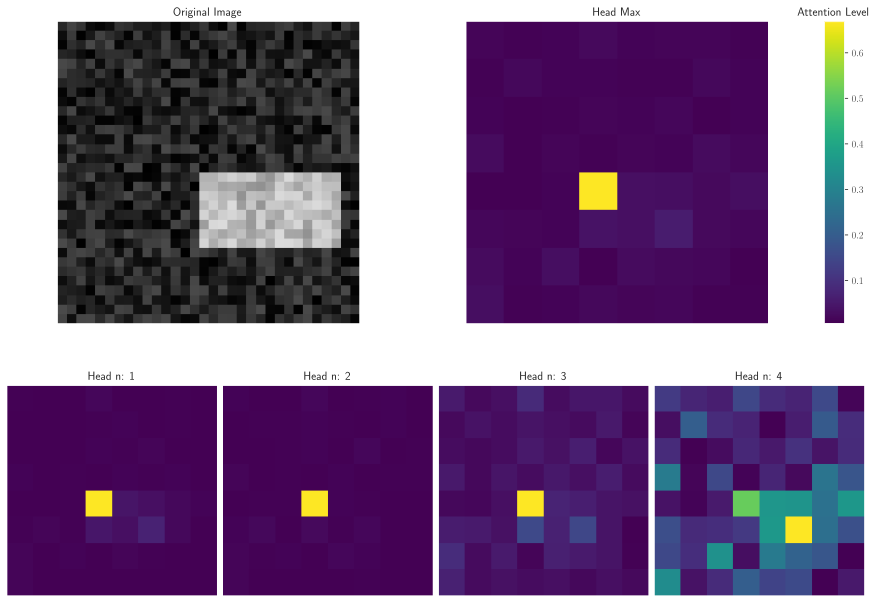

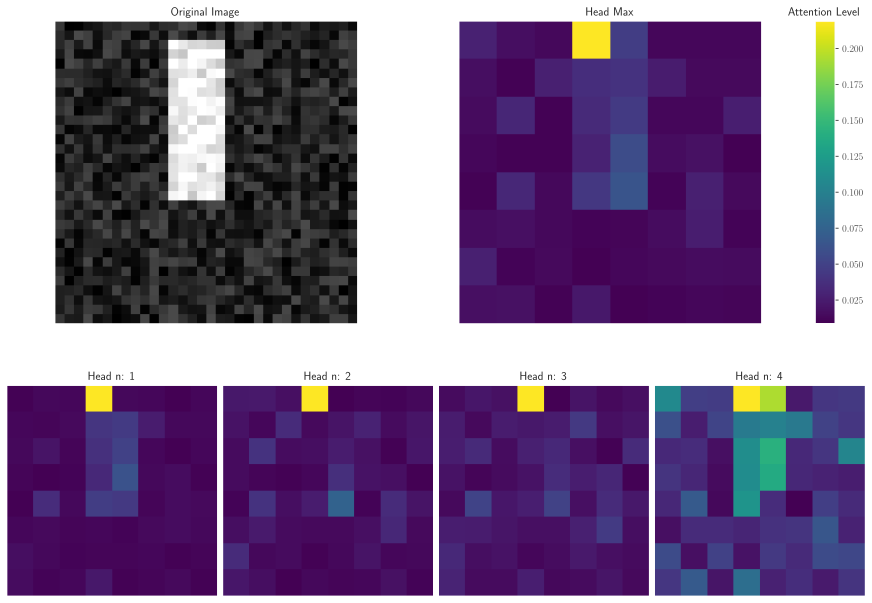

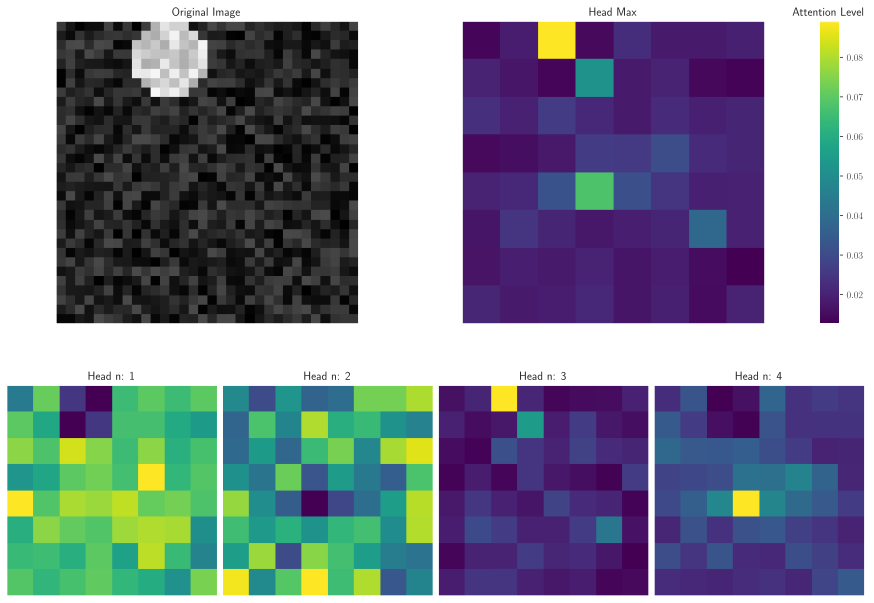

In [ ]:
visualizer = Visualizer(model=transf, patch_size=4)

with torch.no_grad():
    for i, (data_, label_) in enumerate(test_dataloader, 0):
        data_ = data_.to(device)
        label_ = label_.to(device)

        visualizer.visualize_predict(data_)

        if i == 2:
            break


<div style="background-color:rgba(255, 255, 255, 1); text-align:center; vertical-align: middle; padding:40px 0;">

#### <span style="color:blue"> Example.</span>

<table><tr>
<td> <img src="img/example_viz_att_square.svg" alt="Drawing" style="width: 800px;"/> </td>
<td> <img src="img/example_viz_att_circle.svg" alt="Drawing" style="width: 800px;"/> </td>
</tr></table>